# Compare different NN versions

We have different pieces of code that define NNs, either per layer as is typcial or all at once. Compare to make sure they all yield the same results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Input, Dropout, Lambda
from tensorflow.keras.regularizers import Regularizer, l2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD

## Data

In [2]:
# this function was used to generate the data
def generate_data():
    n1, n2, n3 = 8, 1, 1
    data_x = np.round(np.concatenate(
        [np.random.uniform(-10., 0., size=n1), np.random.uniform(10., 10.3, size=n2), 
         np.random.uniform(-7., -6.8, size=n3)], axis=0), 1)
    data_y = np.round(2. * np.sin(data_x / 1.5) + 0.2 * np.random.normal(size=n1+n2+n3), 1)
    return data_x, data_y

# now it is fixed for consistency
data_x = np.array([-4.3, -4.6, -4.8, -3.1, -1.4, -5.6, -6.8, -4.1, -0.5, -2.4, -4.9, -3.6, -8.2, -5.9, -4.0, 
                   -8.5, -8.6, -0.6, -7.0, -7.4, -2.6, -2.9, -9.7, -2.2, -8.1, -1.9, -5.3, -6.7, -8.0, -0.4, 
                   -3.5, -5.8, -2.3, -1.5, -9.8, 10.0, 10.2, 10.1, 10.6, 9.5, -6.8, -7.0, -6.8, -6.9, -6.8]
                 ).reshape((-1, 1))
m_x, s_x = np.mean(data_x), np.std(data_x)
data_y = np.array([-0.6, 0.0, 0.2, -1.8, -1.7, 1.3, 1.8, -0.6, -0.6, -2.2, 0.3, -1.2, 1.5, 1.5, -1.1, 1.1, 1.4, 
                   -0.7, 2.1, 1.8, -1.8, -1.9, -0.1, -2.1, 1.6, -1.9, 0.5, 1.5, 1.3, -0.7, -1.3, 1.6, -2.2, -1.6, 
                   -0.3, 0.7, 1.1, 0.9, 1.0, 0.6, 2.0, 1.9, 1.9, 2.1, 1.9]).reshape((-1, 1))

val_x, val_y = generate_data()

data_x = (data_x-m_x) / s_x
val_x = (val_x.reshape((-1, 1))-m_x) / s_x
val_y = val_y.reshape((-1, 1))

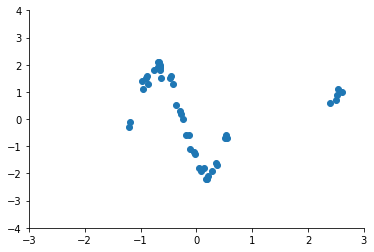

In [3]:
fig, ax = plt.subplots()
xx = np.linspace(-2, 2)
#ax.plot(xx, 2. * np.sin(xx / 1.5), color='gray')
#ax.fill_between(xx, 2. * np.sin(xx / 1.5) - 2 * 0.2, 2. * np.sin(xx / 1.5) + 2 * 0.2, color='gray', alpha=0.4)
ax.plot(data_x, data_y, linestyle='none', marker='o')
ax.set_xlim([-3, 3])
ax.set_ylim([-4, 4])
#ax.grid(True)
for pos in ['right', 'top']: #, 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

## NN using keras layers

In [4]:
# Set some properties of the neural network we will train
layers_shape = (20, 20, 20, 20)
noise_scale = 0.2
prior_scale = 1. # set to 1 learns okay, set to 0.01 learns nothing (too strong regularization to 0)

In [5]:
def negloglikloss(y_true, y_pred, noise_scale):
    scale=tf.cast(noise_scale, tf.float32)
    return -tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(y_true, tf.float32), scale=scale).log_prob(
        tf.cast(y_pred, tf.float32)))

def prior_regularizer(w, prior_scale, prior_loc=0):
    log_prior_weights = tfp.distributions.Normal(loc=prior_loc, scale=prior_scale).log_prob(w)
    return -tf.reduce_sum(log_prior_weights)
    
def architecture_map(layers_shape, noise_scale, prior_scale=1, act='relu', verbose=False, 
                     optimizer=Adam(learning_rate=0.01)):
    reg_func = lambda x: prior_regularizer(x, prior_scale)
    inputs = Input(shape=(1,))
    hidden = Dense(layers_shape[0], activation=act, kernel_regularizer=reg_func, bias_regularizer=reg_func, 
                  kernel_initializer='HeNormal')(inputs)
    for i in range(len(layers_shape)-1):
        hidden = Dense(layers_shape[i+1], activation=act, kernel_regularizer=reg_func, bias_regularizer=reg_func, 
                       kernel_initializer='HeNormal')(hidden)
    outputs = Dense(1, kernel_regularizer=reg_func, bias_regularizer=reg_func, kernel_initializer='HeNormal'
                   )(hidden)
    model = Model(inputs, outputs)
    if verbose:
        model.summary()
    model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: negloglikloss(y_true, y_pred, noise_scale))
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,321
Trainable params: 1,321
Non-trainable par

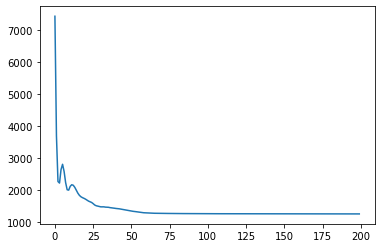

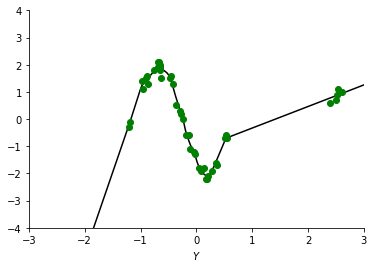

In [6]:
model = architecture_map(layers_shape, prior_scale=prior_scale, noise_scale=noise_scale, act='relu', verbose=1)
train_loss = negloglikloss(data_y, model(data_x), noise_scale=noise_scale)
reg_loss = sum([sum(l_.losses) for l_ in model.layers if 'dense' in l_.name])
print(train_loss, reg_loss)
history = model.fit(data_x, data_y, batch_size=data_x.size, epochs=200, shuffle=True, verbose=False)
plt.plot(history.history['loss'])
print(history.history['loss'][-1])

fig, ax = plt.subplots()
xx = np.linspace(-15, 15, 1000)
ax.plot(xx, model.predict(xx), color='black')
ax.plot(data_x, data_y, linestyle='none', marker='o', color='green', label='training')
ax.set_xlim([-3, 3])
ax.set_ylim([-4, 4])
#ax.grid(True)
for pos in ['right', 'top']: #, 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
ax.set_xlabel('$X$')
ax.set_xlabel('$Y$')
plt.show()

## NN in our code

In [7]:
from Aux import create_nn_per_layer, create_nn_full

49.42071533203125


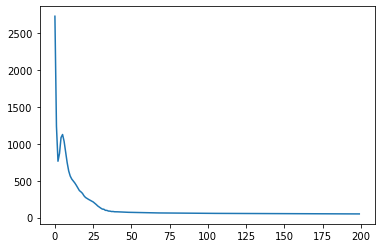

In [8]:
nn = create_nn_per_layer(layers_shape=layers_shape, noise_scale=noise_scale, optimizer=Adam(learning_rate=0.01),
                         lmda_reg=1/(2*prior_scale**2), power_reg=2., prior_weights=None)
history = nn.fit(data_x, data_y, batch_size=data_x.size, epochs=200, shuffle=True, verbose=False)
plt.plot(history.history['loss'])
print(history.history['loss'][-1])

32/32 [==============================] - 0s 2ms/step


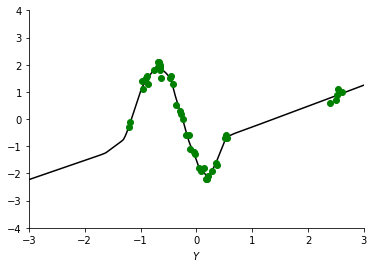

In [9]:
fig, ax = plt.subplots()
xx = np.linspace(-15, 15, 1000)
ax.plot(xx, nn.predict(xx), color='black')
ax.plot(data_x, data_y, linestyle='none', marker='o', color='green', label='training')
ax.set_xlim([-3, 3])
ax.set_ylim([-4, 4])
#ax.grid(True)
for pos in ['right', 'top']: #, 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
ax.set_xlabel('$X$')
ax.set_xlabel('$Y$')
plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 layer_full_nn (LayerFullNN)  (None, 1)                1321      
                                                                 
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 0s 2ms/step


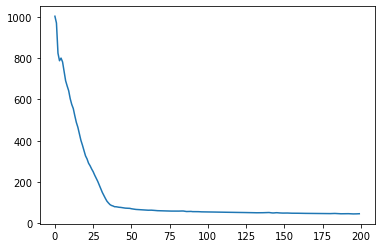

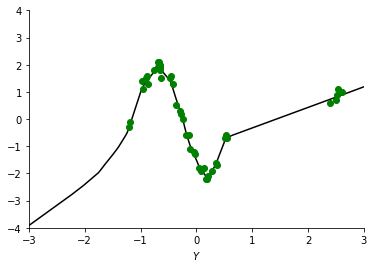

In [10]:
K = 1321
eigenvecs = np.eye(K)
S_vec = np.sqrt(K-1) * prior_scale * np.ones((K,))
nn = create_nn_full(layers_shape=layers_shape, noise_scale=noise_scale, optimizer=Adam(learning_rate=0.01),
                    sing_vectors=eigenvecs, sing_values=S_vec, prior_weights=None, verbose=True)
history = nn.fit(data_x, data_y, batch_size=data_x.size, epochs=200, shuffle=True, verbose=False)
plt.plot(history.history['loss'])

fig, ax = plt.subplots()
xx = np.linspace(-15, 15, 1000)
ax.plot(xx, nn.predict(xx), color='black')
ax.plot(data_x, data_y, linestyle='none', marker='o', color='green', label='training')
ax.set_xlim([-3, 3])
ax.set_ylim([-4, 4])
#ax.grid(True)
for pos in ['right', 'top']: #, 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
ax.set_xlabel('$X$')
ax.set_xlabel('$Y$')
plt.show()